In [4]:
import pandas as pd
import json
import math as m
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LinearRegression
from sklearn import model_selection
import collections
import re

from PIL import Image
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
import matplotlib.pyplot as plt

from nltk.util import ngrams
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.linear_model import SGDClassifier
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import GridSearchCV
from sklearn.feature_extraction.text import TfidfTransformer

In [5]:
data_json = []
with open('data/dblp-ref-0.json') as f:
    for line in f:
        data_json.append(json.loads(line))

In [6]:
df = pd.DataFrame(data_json)

In [7]:
df = df[df['abstract'].notnull()]

In [8]:
research_words = set(line.strip() for line in open('data/research_words.txt'))

In [9]:
parentdomain = {
    "coding theory" : "mathematical foundations",
    "game theory" : "mathematical foundations",
    "graph theory" : "mathematical foundations",
    "mathematical logic" : "mathematical foundations",
    "boolean logic" : "mathematical foundations",
    "number theory" : "mathematical foundations",
    "mathematical foundations" : "mathematical foundations",
    "algorithms" : "algorithms and data structures",
    "data structures" : "algorithms and data structures",
    "algorithms and data structures" : "algorithms and data structures",
    "automated reasoning" : "artificial intelligence",
    "computer vision" : "artificial intelligence",
    "machine learning" : "artificial intelligence",
    "evolutionary computing" : "artificial intelligence",
    "natural language processing" : "artificial intelligence",    
    "artificial intelligence" : "artificial intelligence",
    "neural network" : "artificial intelligence",
    "speech processing" : "artificial intelligence",
    "information retrieval" : "artificial intelligence",
    "data mining" : "artificial intelligence",
    "robotics" : "artificial intelligence",
    "networking" : "communication and security",
    "computer networks" : "communication and security",
    "communication networks" : "communication and security",
    "cryptography" : "communication and security",
    "communication and security" : "communication and security",
    "network protocols" : "communication and security",
    "network attacks" : "communication and security",
    "operating systems" : "computer architecture",
    "computer architecture" : "computer architecture",
    "image processing" : "computer graphics",
    "information visualization" : "computer graphics",
    "visualization" : "computer graphics",
    "visualisation" : "computer graphics",
    "computer graphics" : "computer graphics",
    "parallel computing" : "concurrent, parallel, and distributed systems",
    "concurrency" : "concurrent, parallel, and distributed systems",
    "distributed computing" : "concurrent, parallel, and distributed systems",
    "concurrent, parallel, and distributed systems" : "concurrent, parallel, and distributed systems",
    "relational databases" : "databases",
    "structured storage" : "databases",
    "databases" : "databases",
    "compiler theory" : "programming languages and compilers",
    "programming language" : "programming languages and compilers",
    "programming language pragmatics" : "programming languages and compilers",
    "programming language theory" : "programming languages and compilers",
    "formal semantics" : "programming languages and compilers",
    "type theory" : "programming languages and compilers",
    "programming languages and compilers" : "programming languages and compilers",
    "computational science" : "scientific computing",
    "numerical analysis" : "scientific computing",
    "symbolic computation " : "scientific computing",
    "computational physics" : "scientific computing",
    "computational chemistry" : "scientific computing",
    "bioinformatics" : "scientific computing",
    "computational biology" : "scientific computing",
    "computational neuroscience" : "scientific computing",
    "scientific computing" : "scientific computing",
    "formal methods" : "software engineering",
    "algorithm design" : "software engineering",
    "computer programming" : "software engineering",
    "human–computer interaction" : "software engineering",
    "reverse engineering" : "software engineering",
    "software engineering" : "software engineering",
    "automata theory " : "theory of computation",
    "computability theory" : "theory of computation",
    "computational complexity theory" : "theory of computation",
    "quantum computing" : "theory of computation",
    "theory of computation" : "theory of computation",   
}

In [10]:
df_copy = df.copy()
def getdomainlist(row):
    abst = row['abstract'] if type(row['abstract']) != float else  ""
    venue = row['venue'] if type(row['venue']) != float else  ""
    
    text = abst + " " + row['title'] + " " + venue
    text = text.lower()
    text = re.sub(r'[^a-zA-Z0-9\s]', ' ', text)
    tokens = [token for token in text.split(" ") if token != ""]
    output1 = list(ngrams(tokens, 1))
    output2 = list(ngrams(tokens, 2))
    output3 = list(ngrams(tokens, 3))
    output = []
    for words in output1:
        output.append(' '.join(words))
    for words in output2:
        output.append(' '.join(words))
    for words in output3:
        output.append(' '.join(words))
    domainlist = set()
    for word in output:
        if word in parentdomain:
            domainlist.add(parentdomain[word])
    if len(domainlist) > 0:
        return list(domainlist)[0]
    else:
        return ""

df_copy['domain'] = df_copy.apply(getdomainlist, axis = 1)

In [11]:
dffinal = df_copy[df_copy['domain'].map(lambda x: len(x) >0)]

In [12]:
dffinal['text'] = dffinal[['abstract', 'title']].apply(lambda x: ' '.join(x), axis=1)

/jet/var/python/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


In [13]:
X_train, X_test, y_train, y_test = train_test_split(dffinal['text'].head(30000), dffinal['domain'].head(30000), random_state = 0)

pipeline = Pipeline([('vect', CountVectorizer(stop_words='english')),
                     ('tfidf', TfidfTransformer()),
                     ('clf', SGDClassifier(loss='hinge'))
                     ])

parameters = {
    'vect__max_df': (0.5, 0.75, 1.0),
    # 'vect__max_features': (None, 5000, 10000, 50000),
    'vect__ngram_range': ((1, 1), (1, 2)),  # unigrams or bigrams
    # 'tfidf__use_idf': (True, False),
    # 'tfidf__norm': ('l1', 'l2'),
    'clf__max_iter': (5,),
    'clf__alpha': (0.00001, 0.000001),
    'clf__penalty': ('l2', 'elasticnet'),
    # 'clf__max_iter': (10, 50, 80),
}

grid_search = GridSearchCV(pipeline, parameters, cv=5,n_jobs=10,
                               verbose=1)
grid_search.fit(X_train, y_train)

Fitting 5 folds for each of 24 candidates, totalling 120 fits


[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done  30 tasks      | elapsed:  2.4min
[Parallel(n_jobs=10)]: Done 120 out of 120 | elapsed: 12.1min finished
/jet/var/python/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


GridSearchCV(cv=5, error_score='raise-deprecating',
       estimator=Pipeline(memory=None,
     steps=[('vect', CountVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
        lowercase=True, max_df=1.0, max_features=None, min_df=1,
        ngram_range=(1, 1), preprocessor=None, stop_words='english',
        ...m_state=None, shuffle=True, tol=None,
       validation_fraction=0.1, verbose=0, warm_start=False))]),
       fit_params=None, iid='warn', n_jobs=10,
       param_grid={'vect__max_df': (0.5, 0.75, 1.0), 'vect__ngram_range': ((1, 1), (1, 2)), 'clf__max_iter': (5,), 'clf__alpha': (1e-05, 1e-06), 'clf__penalty': ('l2', 'elasticnet')},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=1)

In [14]:
df['text'] = df[['abstract', 'title']].apply(lambda x: ' '.join(x), axis=1)

In [15]:
len(df)

753646

In [16]:
df

,abstract,authors,id,n_citation,references,title,venue,year,text
0,The purpose of this study is to develop a lear...,"[Makoto Satoh, Ryo Muramatsu, Mizue Kayama, Ka...",00127ee2-cb05-48ce-bc49-9de556b93346,0,"[51c7e02e-f5ed-431a-8cf5-f761f266d4be, 69b625b...",Preliminary Design of a Network Protocol Learn...,international conference on human-computer int...,2013,The purpose of this study is to develop a lear...
1,This paper describes the design and implementa...,"[Gareth Beale, Graeme Earl]",001c58d3-26ad-46b3-ab3a-c1e557d16821,50,"[10482dd3-4642-4193-842f-85f3b70fcf65, 3133714...",A methodology for the physically accurate visu...,visual analytics science and technology,2011,This paper describes the design and implementa...
2,This article applied GARCH model instead AR or...,"[Altaf Hossain, Faisal Zaman, Mohammed Nasser,...",001c8744-73c4-4b04-9364-22d31a10dbf1,50,"[2d84c0f2-e656-4ce7-b018-90eda1c132fe, a083a1b...","Comparison of GARCH, Neural Network and Suppor...",pattern recognition and machine intelligence,2009,This article applied GARCH model instead AR or...
10,Recent achievements in Natural Language Proces...,"[Ankita Brahmachari, Priya Singh, Avdhesh Garg...",00a119c4-d367-4607-b3c8-b237f2971bff,0,"[84d47128-58d0-4187-aa44-389fde7d5c83, e0dce69...",Identifying Psychological Theme Words from Emo...,,2013,Recent achievements in Natural Language Proces...
12,"Recently, Bridges and Reich introduced the con...","[Alvaro L. Islas, Constance M. Schober]",00bcf2d5-1592-46b0-81fd-933f90b5ecca,50,[],Multisymplectic Spectral Methods for the Gross...,international conference on conceptual structures,2002,"Recently, Bridges and Reich introduced the con..."
13,Most applications of the abstract interpretati...,"[Patrick Cousot, Radhia Cousot]",00c85316-bddf-4bcb-93f5-097adadd73c2,50,"[6e8a3ec3-9a99-4fac-ac4d-f8d1bf0fa208, 7bb71af...",Relational Abstract Interpretation of Higher O...,,1991,Most applications of the abstract interpretati...
14,Three speech training systems for hearing-impa...,"[Minoru Shigenaga, Yoshihiro Sekiguchi]",00ca027b-5174-40fa-bf63-9a97c2a5f518,0,NaN,Speech training systems using lateral shapes o...,international joint conference on artificial i...,1979,Three speech training systems for hearing-impa...
16,This paper focuses on knowledge engineering fo...,"[Efthymios Alepis, Maria Virvou, Katerina Kaba...",00dd5ece-1339-4cb6-a08e-43742ae2dac6,50,"[522bea13-bd45-4918-9478-e87ae2f039f7, 60507d4...",Knowledge Engineering for Affective Bi-Modal I...,joint conference on knowledge-based software e...,2008,This paper focuses on knowledge engineering fo...
20,Embedded systems often have limited amounts of...,"[Matias Madou, Bjorn De Sutter, Bruno De Bussc...",01047814-b615-4449-9a30-8ef36c3c1693,50,NaN,Link-time compaction of MIPS programs,european symposium on algorithms,2004,Embedded systems often have limited amounts of...
22,Xax is a browser plugin model that enables dev...,"[John R. Douceur, Jeremy Elson, Jon Howell, Ja...",010d4ce9-0279-4166-ae73-14551ded6404,50,"[0abc9de7-e047-44fc-998d-4bf02b9bc9ab, 2c9ebc3...",Leveraging legacy code to deploy desktop appli...,operating systems design and implementation,2008,Xax is a browser plugin model that enables dev...


In [17]:
answer = grid_search.predict(df['text'].values.tolist())

In [18]:
df['domain'] = answer.tolist()

In [19]:
df1 = df.head(10000)

In [20]:
atod = {}
def domains(row):
    for i in row['authors']:
        if i not in atod:
            atod[i] = []
            atod[i].append(row['domain'])
        else:
            atod[i].append(row['domain'])
        
x = df1.apply(domains, axis = 1)

In [21]:
paper_citations = df1['n_citation'].values.tolist()

In [22]:
author_matrix = df1['authors'].values.tolist()

In [23]:
result = set(x for l in author_matrix for x in l)

In [24]:
result = list(result)

In [25]:
len(result)

26699

In [26]:
name_map = {}
name_map_reverse = {}
for index, i in enumerate(result):
    name_map[i] = index
    name_map_reverse[index] = i

In [27]:
ptoa = {}
atop = {}
ptoc = {}
author_to_papersum = {}
author_to_papercite = {}
author_to_author = {}
for index, x in enumerate(author_matrix):
    ptoa[index] = x
    for author in x:
        if author not in atop:
            atop[author] = []
        if author not in author_to_author:
            author_to_author[author] = {}
        for aut in x:
            if aut != author :
                if aut not in author_to_author[author]:
                    author_to_author[author][aut] = 1
                else:
                    author_to_author[author][aut] +=1
        atop[author].append(index)
for index, i in enumerate(paper_citations):
    ptoc[index] = i
for author in name_map.keys():
    author_to_papersum[author] = len(atop[author])
for author in name_map.keys():
    author_to_papercite[author] = 0
    for v in atop[author]:
        author_to_papercite[author] += ptoc[v]
aut_year = df1[['authors', 'year']].values.tolist()
author_years = {}
for index, x in enumerate(aut_year):
    year = int(x[1])
    authors = x[0]
    for author in authors:
        if author not in author_years:
            author_years[author] = {}
            author_years[author]['max'] = year
            author_years[author]['min'] = year
        else:
            author_years[author]['max'] = max(author_years[author]['max'], year)
            author_years[author]['min'] = min(author_years[author]['min'], year)

In [28]:
adj = {}
for x in atop.keys():
    if name_map[x] not in adj:
        adj[name_map[x]] = set()
    for paper in atop[x]:
        for aut in ptoa[paper]:
            if aut == x: continue 
            adj[name_map[x]].add(name_map[aut])
from collections import OrderedDict
adj_sorted = sorted(adj.items(), key=lambda kv: kv[0])
adj1 = OrderedDict()
for x in adj_sorted:
    key = x[0]
    value = x[1]
    adj1[key] = value

In [29]:
def hIndex(citations):
    h = [0] * (len(citations) + 1)
    for i in citations:
        if i > len(citations):
            h[-1] += 1
        else:
            h[i] += 1
        sum_c = 0
    for i,j in enumerate(h[::-1]):
            sum_c = sum_c + j
            if sum_c >= len(citations) - i:
                return(len(citations) - i)
    return 0

In [30]:
atoh = {}
for x in atop:
    l = []
    for p in atop[x]:
        l.append(ptoc[p])
    atoh[x] = hIndex(l)
atoh1 = {}
for author in adj1:
    author_name = name_map_reverse[author]
    atoh1[author_name] = atoh[author_name]

In [31]:
sociability = {}
for author1 in adj1:
    author_name = name_map_reverse[author1]
    temp_social = 0
    for coauthor in author_to_author[author_name]:
        temp_social += m.log(author_to_author[author_name][coauthor])
    sociability[author_name] = 1 + temp_social

In [32]:
longevity = {}
for author1 in adj1:
    author_name = name_map_reverse[author1]
    longevity[author_name] = author_years[author_name]['max'] - author_years[author_name]['min'] + 1

In [33]:
atod1 = {}
for author1 in adj1:
    author_name = name_map_reverse[author1]
    atod1[author_name] = atod[author_name]

In [34]:
diversity = {}
for index in atod1:
    diversity[index] = len(atod1[index])

In [35]:
len(adj)

26699

In [36]:
adj1

OrderedDict([(0,
              {1734,
               2938,
               5171,
               10189,
               10348,
               11033,
               11053,
               11928,
               13561,
               13931,
               14847,
               21139,
               22363,
               22447,
               23535,
               25302,
               26509,
               26665}),
             (1, {6366, 9607, 12681}),
             (2, {475, 1435, 12236, 20685}),
             (3, {11109, 19489, 20348}),
             (4, {7046, 23524}),
             (5, {3256, 17973}),
             (6, {17049}),
             (7, {422, 4372, 9798, 11078, 15625, 22044, 24082}),
             (8, {19985, 22014}),
             (9, set()),
             (10, {5805, 13593}),
             (11, {205, 1951, 3073, 9497, 16198, 16251}),
             (12, {7448}),
             (13, {1704, 7059, 8270, 11263, 14237}),
             (14, set()),
             (15, {5735, 17739, 23120}),
       

In [37]:
adj_list = [[0 for i in range(len(adj1))] for i in range(len(adj1))]
for key in adj1:
    for val in adj1[key]:
        adj_list[key][val] = 1

In [38]:
from collections import OrderedDict
def degree(matrix,i):
    count = 0
    for j in range(len(matrix[i])):
        if matrix[i][j] != 0:
            count = count + 1
    return count
def create_list(ei, ej, matrix):
    adjL = []
    adj_map = {}
    for i in range(len(matrix)):
        adj_map[i] = []
        adjL.append([])
    m = len(ei)
    for i in range(m):
        u = ei[i]
        v = ej[i]
        adj_map[u].append(v)
        adjL[u].append(v)
    return adjL, adj_map
def create_enchanced(mat1, mat2):
    for i in range(len(mat1)):
        for nodeStep in mat1[i]:
            for node in mat1[nodeStep]:
                if (node != i) & (node not in mat2[i]):
                    mat2[i].append(node)
    return mat2
def cohesionCentrality(adj_list,edge_i, edge_j):
    inf = {}
    for i in range(len(adj_list)):
        deg = degree(adj_list, i)
        inf[i] = deg
    tolerance = 0.5
    blacklist = (int) (tolerance * len(adj_list))
    bl = []
    sl = []
    inf_sorted = sorted(inf.items(), key=lambda kv: kv[1])
    inf1 = OrderedDict()
    for x in inf_sorted:
        key = x[0]
        value = x[1]
        inf1[key] = value
    black = inf1.keys()
    j=0
    for i in black:
        if j <  blacklist:
            bl.append(i)
        elif j >= blacklist:
            sl.append(i)
        j = j + 1
    #Cohesion Algo Begins
    edge = []
    for i in range(len(edge_i)):
        edge.append((edge_i[i], edge_j[i]))
    for x in range(5):
        for i in edge:
            if i[0] in bl:
                edge.remove(i)
        for i in edge:
            if i[1] in bl:
                edge.remove(i)
    edge_i = []
    edge_j = []
    for i in edge:
        edge_i.append(i[0])
        edge_j.append(i[1])
    adjL1,adj_map1 = create_list(edge_i, edge_j, adj_list)
    adjL2,adj_map2 = create_list(edge_i, edge_j, adj_list)
    adjL3,adj_map3 = create_list(edge_i, edge_j, adj_list)
    adjL4,adj_map4 = create_list(edge_i, edge_j, adj_list)
    adjL5,adj_map5 = create_list(edge_i, edge_j, adj_list)
    adj_map2 = create_enchanced(adj_map1, adj_map2)
    adj_map3 = create_enchanced(adj_map2, adj_map3)
    lll = []
    for i in range(len(adjL3)):
        lll.append(len(adjL3[i]))
    mp = {}
    for i in range(len(lll)):
        if lll[i] != 0:
            mp[i] = lll[i]
    master = [0] * len(adj_list)
    count_0 = []
    count_2 = []
    count_3 = []
    count_4 = []
    for lst in adjL1:
        count_0.append(len(lst))
    for lst in adjL3:
        count_2.append(len(lst))
    threshold = 0.3
    for i in range(len(count_0)):
        if (count_0[i] !=0) & (count_2[i] != 0):
            if (float(count_0[i]) / float(count_2[i])) < threshold:
                master[i] = count_2[i]
                adjL3[i].clear()
                adjL4[i].clear()
                adjL5[i].clear()
    adj_map4 = create_enchanced(adj_map3, adj_map4)
    for lst in adjL4:
        count_3.append(len(lst))
    for i in range(len(count_0)):
        if (count_0[i] !=0) & (count_3[i] != 0):
            if (float(count_0[i]) / float(count_3[i])) < threshold:
                master[i] = count_3[i]
                adjL4[i].clear()
                adjL5[i].clear()
    adj_map5 = create_enchanced(adj_map4, adj_map5)
    for lst in adjL5:
        count_4.append(len(lst))
    for i in range(len(count_0)):
        if (count_0[i] !=0) & (count_4[i] != 0):
            if (float(count_0[i]) / float(count_4[i])) < threshold:
                master[i] = count_4[i]
                adjL5[i].clear()
        elif (count_0[i] !=0) & (count_4[i] != 0):
            if (float(count_0[i]) / float(count_4[i])) > threshold:
                master[i] = count_4[i]
    for index in range(len(master)):
        if master[index] == 0:
            master[index] = inf[index]
    return master

In [39]:
edge_i = []
edge_j = []
for i in range(len(adj_list)):
    for j in range(len(adj_list)):
        if adj_list[i][j] != 0:
            edge_i.append(i)
            edge_j.append(j)

In [40]:
master = cohesionCentrality(adj_list, edge_i, edge_j)
index = -1
max_influence = 0
for i in range(len(master)):
    if master[i] > max_influence:
        max_influence = master[i]
        index = i
for key, value in name_map.items():
    if value == index:
        print(key)

Matthias Samwald


In [41]:
max_influence

68

In [42]:
import numpy as np
df = pd.DataFrame(np.column_stack([edge_i, edge_j]), columns=['node1', 'node2'])
adj_list1 = adj_list.copy()
df['weight'] = np.ones(len(df))
df['weight'] = df['weight'].astype(int)
df.to_csv('list.csv', index = False, header = False)

In [43]:
import networkx as nx
graph = nx.from_pandas_edgelist(df, 'node1', 'node2')
pr = nx.pagerank(graph, alpha=0.5)
author_pagerank = {}
for key in name_map:
    v = name_map[key]
    if v not in pr:
        author_pagerank[key] = 0
    else:
        author_pagerank[key] = pr[v]

In [44]:
train = pd.DataFrame(columns=['num_papers', 'num_citations','page_rank_score'])
train['num_papers'] = pd.Series(author_to_papersum)
train['num_citations'] = pd.Series(author_to_papercite)
train['page_rank_score'] = pd.Series(author_pagerank)
train['sociability'] = pd.Series(sociability)
train['longevity'] = pd.Series(longevity)
train['h-index'] = pd.Series(atoh1)
train['diversity'] = pd.Series(diversity)

In [45]:
len(author_to_papercite)

26699

In [46]:
X_train , X_test, Y_train , Y_test = model_selection.train_test_split(
    train, master, test_size=0.25, random_state = 5)
lr = LinearRegression()
model = lr.fit(X_train, Y_train)
train_score = lr.predict(X_train)
test_score = lr.predict(X_test)
mean_squared_error(Y_test, test_score)

8.6624130395331527

In [47]:
import lightgbm as lgb
X_train , X_test, Y_train , Y_test = model_selection.train_test_split(
    train, master, test_size=0.25, random_state = 5)
params_lgb = {"objective" : "regression", "metric" : "rmse", "bagging_fraction" : 0.76, "feature_fraction" : 0.8, "bagging_frequency" : 6,
            "num_leaves" : 35, "learning_rate" : 0.06 }
reg = lgb.LGBMRegressor(
       n_estimators=1000,
       subsample=.9,
       colsample_bytree=.9,
       random_state=1,
       **params_lgb
)
prediction_model = reg.fit(
       X_train, Y_train,
       eval_set=[(X_test, Y_test)],
       early_stopping_rounds=150,
       verbose = 100,
       eval_metric='rmse'
)

Training until validation scores don't improve for 150 rounds.
[100]	valid_0's rmse: 1.77485
[200]	valid_0's rmse: 1.76344
[300]	valid_0's rmse: 1.75971
[400]	valid_0's rmse: 1.75545
[500]	valid_0's rmse: 1.75161
[600]	valid_0's rmse: 1.75149
[700]	valid_0's rmse: 1.75023
[800]	valid_0's rmse: 1.74765
[900]	valid_0's rmse: 1.74748
[1000]	valid_0's rmse: 1.74723
Did not meet early stopping. Best iteration is:
[923]	valid_0's rmse: 1.74671


In [48]:
predictions = lr.predict(train)

In [49]:
predictions = predictions.tolist()

In [50]:
top_authors = {}
for index in range(len(predictions)):
    top_authors[name_map_reverse[index]] = predictions[index]

In [51]:
import operator
sorted_x = sorted(top_authors.items(), key=operator.itemgetter(1), reverse=True)

In [52]:
top_100_authors_model = sorted_x[:100]

/jet/var/python/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2053: FutureWarning: You should specify a value for 'cv' instead of relying on the default value. The default value will change from 3 to 5 in version 0.22.
  warnings.warn(CV_WARNING, FutureWarning)


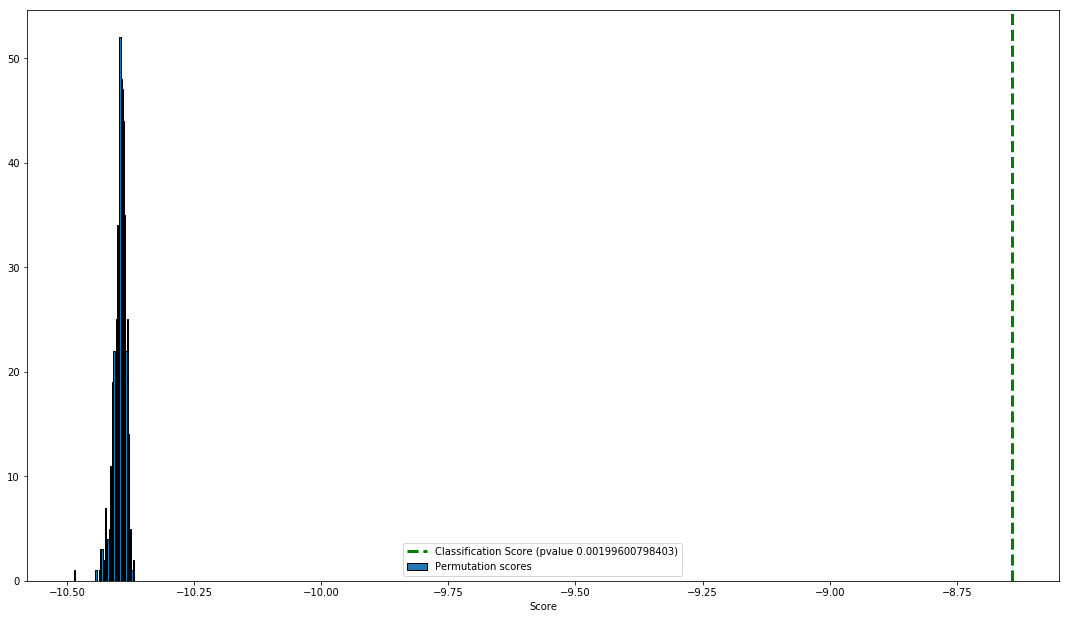

In [53]:
from sklearn.model_selection import permutation_test_score
import matplotlib.pyplot as plt
fig = plt.figure()
fig.set_size_inches(18.5, 10.5)
score, permutation_scores, pvalue = permutation_test_score(lr, X_test, Y_test, n_permutations=500, n_jobs=1,scoring='neg_mean_squared_error')
plt.hist(permutation_scores, 50, label='Permutation scores',edgecolor='black')
ylim = plt.ylim()
plt.plot(2*[score], ylim, '--g', linewidth=3,label='Classification Score (pvalue %s)' % pvalue)
plt.ylim(ylim)
plt.legend()
plt.xlabel('Score')
plt.show()

In [54]:
h_index_values = train['h-index'].values.tolist()

In [55]:
from scipy.stats.stats import pearsonr

In [56]:
pearsonr(predictions, h_index_values)

(0.348835118847583, 0.0)

In [57]:
sorted_x1 = sorted(atoh.items(), key=operator.itemgetter(1), reverse=True)

In [58]:
top_100_authors_hindex = sorted_x1[:100]

In [59]:
model_aut = []
for i in top_100_authors_model:
    model_aut.append(i[0])
model_hin = []
for i in top_100_authors_hindex:
    model_hin.append(i[0])

In [60]:
common = []
for i in model_aut:
    if i in model_hin:
        common.append(i)

In [61]:
len(common)

26

In [62]:
top_authors

{'Zheng-Jun Zha': 5.568868140915815,
 'Neno Henrique da Cunha Albernaz': 3.2099803317736892,
 'Ulrich Hegerl': 2.970530334309986,
 'Matteo Mordacchini': 3.2106250913923837,
 'David P. Miller': 3.2251321828130273,
 'Florian Geyer': 2.408090878362527,
 'David Makinson': 1.9753813348857783,
 'Zhao Lu': 3.1501694406174625,
 'Francesco De Rango': 2.60881616622141,
 'Gabor T. Herman': -1.0498922097299812,
 'Bradford W. Mott': 2.3889308374784877,
 'Joanna Skubisz': 3.2527136678582647,
 'Łukasz Sosnowski': 3.2251321828130273,
 'Elif Bilge Kavun': 4.991241006563679,
 'William D. Mark': -1.0498922097299812,
 'Sinnojialin Pan': 2.930039293424505,
 'Sigeru Sato': 3.265752038790829,
 'Gordon M. Shepherd': 3.2314693009058875,
 'Mohamed Ali Kaafar': 2.9143931570844828,
 'Arturo Zavala-Río': 3.2251321828130273,
 'Atsuko K. Yamazaki': 3.2103027115830365,
 'Jerzy Jelonkiewicz': 3.2109474712017327,
 'Mark Minas': 5.07856733065205,
 'Robert McCaa': 3.2122369904391235,
 'Sodany Kiv': 3.2251321828130273,
 '

In [63]:
len(common)

26